## Exploratory data analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
commit_metrics_df = pd.read_csv("data/results/tiny/ml_proj2022.csv", index_col=0)

commit_metrics_df['date'] = pd.to_datetime(commit_metrics_df['date'], utc=True)

In [15]:
commit_metrics_df.head()

,hash,author,date,commit_message,is_merge,codebase_size,lines_changed,total_lines_changed,insertions,deletions,...,radon_comments,radon_avg_cc,radon_avg_MI,radon_avg_vocabulary,radon_avg_length,radon_avg_volume,radon_avg_difficulty,radon_avg_effort,radon_avg_time,radon_avg_bugs
0,024de05ca1d813015aee3ed0d45ec9c6651221ed,Marcin Sroka,2022-11-29 11:33:13+00:00,initial commit 2,False,221,221,221,221,0,...,4,1.222222,93.245436,2.000000,2.000000,3.169925,0.333333,1.584963,0.088053,0.001057
1,db4d3f76041b42e472f5137b381084a8d632ec29,msro,2022-11-30 13:08:53+00:00,"nn tweaks, restructucture models",False,200,53,274,16,37,...,4,1.222222,93.245436,2.000000,2.000000,3.169925,0.333333,1.584963,0.088053,0.001057
2,111bd78ba384e797b6e1b58e68a2f5e339b10ebb,msro,2022-12-04 12:50:21+00:00,Switch pipeline methods to class,False,249,155,429,102,53,...,7,1.466667,84.169089,4.666667,7.000000,22.341552,1.214286,66.027477,3.668193,0.007447
3,74212ebfd4fb11834958b8f936aa9d3deb7e0497,msro,2022-12-04 15:04:41+00:00,introduce fashion dataset to scripts,False,305,142,571,99,43,...,7,1.466667,81.298273,5.333333,10.333333,30.818278,1.825397,88.712269,4.928459,0.010273
4,a4f13784f404c0489b0e0ee5ef7cd8d2bdf4166a,msro,2022-12-12 11:10:01+00:00,"fix fnn, tweaks",False,366,183,754,122,61,...,1,1.388889,78.346024,6.333333,12.333333,39.530243,1.822222,109.136729,6.063152,0.013177


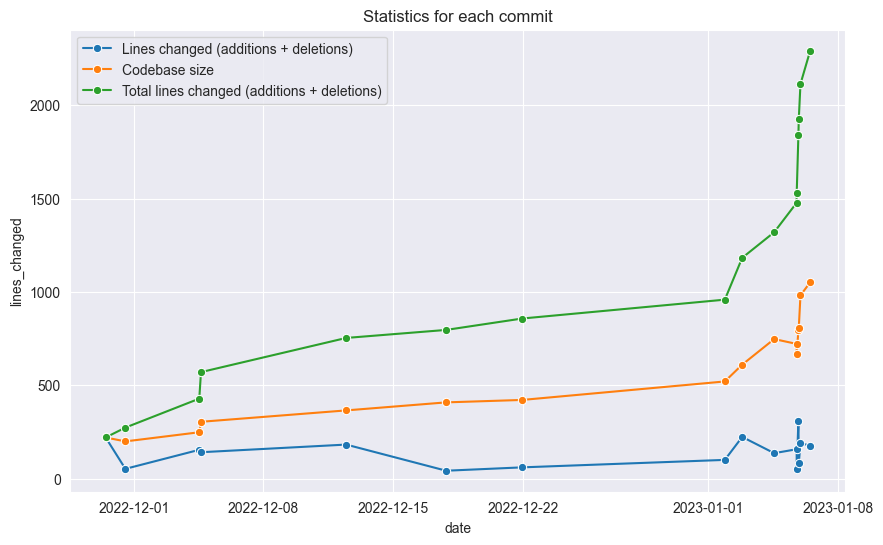

In [16]:
plt.figure(figsize=(10, 6))

# Filter commits by date for partially stagnant repos.
# commit_metrics_until_stagnant = commit_metrics_df[commit_metrics_df['date'] < pd.Timestamp(2017, 1, 1, 12).tz_localize('Europe/Stockholm')]
commit_metrics_until_stagnant = commit_metrics_df

sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='lines_changed', marker='o', label='Lines changed (additions + deletions)')
sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='codebase_size', marker='o', label='Codebase size')
sns.lineplot(data=commit_metrics_until_stagnant, x='date', y='total_lines_changed', marker='o', label='Total lines changed (additions + deletions)')
plt.legend()
plt.title("Statistics for each commit");